## HSMA 3D - Exercise 2 - Facility Location Problems

Working in your PSGs, use what you have just observed (and learned) to tackle the following case study. 

### Case Study: Cardiac Screening Clinics in Cornwall

This case study is set in Cornwall where there are five major locations for these clinics. The locations are:

* Royal Cornwall Hospital Trust (RCHT)
* Cambourne Redruth Community Hospital (CRCH)
* St. Austell Community Hospital (SACH)
* Bodmin Community Hospital (BODMIN)
* West Cornwall Hospital (WCH)

Local NHS commissioners are considering the future of the service. 

They feel that five clinic locations is leading to variation in the quality of patient treatment and would like to **consolidate to three locations.** 

*They have asked for our help in making and supporting their decision making.*

The data provided comprises of:

* *cardiac_clinic_travel_matrix.csv* - Travel time matrix from different locations
* *cardiac_clinic_attendances.csv* - Number of cardiac clinic attendances per LSOA

---
*The first cell only needs to be run if running in colab!* 

In [ ]:
!pip install contextily
!pip install routingpy
!git clone https://github.com/hsma-programme/h6_3d_facility_location_problems.git
%cd /content/h6_3d_facility_location_problems/h6_3d_facility_location_problems/solutions

## Core

Run the code below to import the libraries we'll need.

In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import folium
import contextily as cx
import numpy as np

# Additionally, we'll also use....
# combinations from the itertools library allows us to enumerate all
# solutions (for small instances).
from itertools import combinations

In addition, run the cell below to load in the FacilityLocationObjective class.

In [2]:
# Tweaked WeightedAverageObjective from Metapy package
# https://github.com/health-data-science-OR/healthcare-logistics/tree/master/optimisation/metapy
# Credit: Tom Monks

class FacilityLocationObjective:
    '''
    Encapsulates logic for calculation of
    metrics in a simple facility location problem

    Demand and travel matrices must have a common column

    demand: pd.dataframe:  Two column dataframe. One column should be labels for the
    demand locations (e.g. LSOA identifiers, postcodes). Second column should contain
    demand figures of some kind (e.g. number of historical cases)
    If demand assumed to be equal, all values in this column could be 1.

    travel_matrix: pd.dataframe: dataframe with columns representing sites
    and rows representing locations demand will come from.
    One column should be labels for the demand locations (e.g. LSOA identifiers, postcodes).
    All other values will be either distance or time in float form.
    No additional columns of information must be included or they will be used as part of the
    calculation of the lowest-cost solution, which may lead to incorrect results.
    '''
    def __init__(self, demand, travel_matrix, merge_col, demand_col):
        '''
        Store the demand and travel times

        Args:
            demand: pd.DataFrame:

            travel_matrix: pd.DataFrame:
        '''
        self.demand = demand.set_index(merge_col)
        self.travel_matrix = travel_matrix.set_index(merge_col)
        self.demand_col = demand_col


    def evaluate_solution(self, site_list):
        '''
        Calculates the

        Args:
            site_list: list: column indices of solution to evaluate
                            (to apply to travel matrix)

        Returns:
            Pandas dataframe to pass to evaluation functions

        '''

        active_facilities = self.travel_matrix.iloc[:, site_list].copy()

        # Assume travel to closest facility
        # Need to drop the column that contains
        active_facilities['min_cost'] = active_facilities.min(axis=1)


        # Merge demand and travel times into a single DataFrame
        problem = self.demand.merge(active_facilities,
                                    left_index=True, right_index=True,
                                    how='inner')

        return problem.reset_index()


    def generate_solution_metrics(self, site_list):
        '''
        Calculates the weighted average travel time for selected sites

        Args:
            site_list: list or np.array: A list of site IDs as a list or array (e.g. [0, 3, 4])
            merge_col: string: The column name to use for merging the data.
            n_patients_or_referrals_col: string: The column name to use for the number of patients or referrals.

        Returns:
            A tuple containing the problem and the maximum travel time.
        '''
        problem = self.evaluate_solution(site_list)

        # Return weighted average
        weighted_average = np.average(problem['min_cost'], weights=problem[self.demand_col])
        unweighted_average = np.average(problem['min_cost'])
        max_travel = np.max(problem['min_cost'])

        return {
            'site_indices': site_list,
            'site_names': ", ".join(self.travel_matrix.columns[site_list].tolist()),
            'weighted_average': weighted_average,
            'unweighted_average': unweighted_average,
            'max': max_travel,
            'problem_df': problem
        }

### Data Imports
Now we need to import the travel matrix file named `cardiac_clinic_travel_matrix.csv` and check that the file has been read correctly.

In [3]:
travel_matrix = pd.read_csv(
    '../datasets/exercise_2/cardiac_clinic_travel_matrix.csv'
    )
travel_matrix.head()

,sector,SACH,BODMIN,RCHT,CRCH,WCH
0,E01018750,40,31,60,66,87
1,E01018751,40,31,60,66,87
2,E01018752,41,32,61,67,88
3,E01018753,43,34,64,69,90
4,E01018754,46,38,67,72,93


Next, import the number of `cardiac_clinic_attendances.csv` file (in the same location). Again, check it's been read correctly.

In [4]:
attends = pd.read_csv(
    '../datasets/exercise_2/cardiac_clinic_attendances.csv'
    )
attends.head()

,sector,n_patients
0,E01018757,3
1,E01018758,10
2,E01018761,19
3,E01018763,2
4,E01018768,6


Now we will create our location problem object.

In [5]:
facility_location_problem = FacilityLocationObjective(
    demand=attends,
    travel_matrix=travel_matrix,
    merge_col="sector",
    demand_col="n_patients"
    )

### Constructing and evaluating a Random Solution

From the above you'll have seen that you've been provided with a travel matrix containing 5 clinic locations. For this case study, the 'solution' will comprise of 3 proposed clinics.

Now it's time to generate a random solution. First, run the code in the cell below to define the random_solution function.

In [6]:
def random_solution(n_candidates, p, random_seed=None):
    '''
    Helper function to generate a random solution

    Params
    ------
    n_candidates : int
        The number of candidate locations where you could place
        clinics (facilities).

    p : int
        The number of clinics to place.

    random_seed : int (Default=None)
        Random seed for reproducibility.

    Returns
    -------

    Vector (np.array) of length p
    '''
    # create a random number generator
    rng = np.random.default_rng(seed=random_seed)

    # sample without replacement
    solution = []
    while len(solution) < p:
        candidate = rng.integers(0, n_candidates)
        if candidate not in solution:
            solution.append(candidate)

    return np.array(solution)

Next, fill in the blanks in the use of the function below to generate a single solution for 3 proposed clinics (of the 5 possible locations).

Look at the output of this object.

In [7]:
random_solution_1 = random_solution(
    n_candidates= 5,
    p= 3, ## YOUR CODE HERE
    random_seed=42
)

random_solution_1

array([0, 3, 2], dtype=int64)

Now let's evaluate this solution using the `.evaluate_solution()` method of our `facility_location_problem` object. You will need to provide the list of sites to this method.

You don't need to save the result of this cell into a variable - we are just interested in seeing what it returns. 

In [8]:
facility_location_problem.evaluate_solution(
    site_list = random_solution_1
)

,sector,n_patients,SACH,CRCH,RCHT,min_cost
0,E01018757,3,42,68,63,42
1,E01018758,10,25,51,45,25
2,E01018761,19,33,61,56,33
3,E01018763,2,40,66,60,40
4,E01018768,6,30,56,51,30
...,...,...,...,...,...,...
85,E01019057,51,8,41,30,8
86,E01019064,24,17,27,21,17
87,E01019071,20,9,27,22,9
88,E01033289,29,30,41,36,30


This time, let's return the metrics from this solution.

In [9]:
metrics_random_solution_1 = facility_location_problem.generate_solution_metrics(
    site_list = random_solution_1
)

metrics_random_solution_1

{'site_indices': array([0, 3, 2], dtype=int64),
 'site_names': 'SACH, CRCH, RCHT',
 'weighted_average': 15.133891213389122,
 'unweighted_average': 20.988888888888887,
 'max': 58,
 'problem_df':        sector  n_patients  SACH  CRCH  RCHT  min_cost
 0   E01018757           3    42    68    63        42
 1   E01018758          10    25    51    45        25
 2   E01018761          19    33    61    56        33
 3   E01018763           2    40    66    60        40
 4   E01018768           6    30    56    51        30
 ..        ...         ...   ...   ...   ...       ...
 85  E01019057          51     8    41    30         8
 86  E01019064          24    17    27    21        17
 87  E01019071          20     9    27    22         9
 88  E01033289          29    30    41    36        30
 89  E01033291           7    35    53    48        35
 
 [90 rows x 6 columns]}

Run the code below to convert it into a dataframe. is this easier to read?

Hint - the code below makes a copy of the dictionary `metrics_random_solution_1`.

It then updates `metrics_random_solution_1_copy` so that it doesn't contain the `problem_df`. 

If we tried to make a dataframe out of the whole thing, we'd run into an error!

Try taking some time to understand what the `.join` method is doing. This is a handy bit of code for tidying up the output of your lists when you want to display them nicely.

In [10]:
metrics_random_solution_1_copy = metrics_random_solution_1.copy()

del metrics_random_solution_1_copy["problem_df"]
metrics_random_solution_1_copy["site_indices"].sort()
metrics_random_solution_1_copy["site_indices"] = ", ".join(str(x) for x in metrics_random_solution_1_copy["site_indices"])

pd.DataFrame(metrics_random_solution_1_copy, index=[0])

,site_indices,site_names,weighted_average,unweighted_average,max
0,"0, 2, 3","SACH, CRCH, RCHT",15.133891,20.988889,58


### Create all Possible Combinations

The `all_combinations` function has been provided below.

Can you remember what a list comprehension is? 

Where is it used in the function below and what is it doing?

In [11]:
def all_combinations(n_facilities, p):
    '''
    n_facilities : int
        The number of candidate locations where you could place facilities (clinics).

    p : int
        The number of clinics to place.

    Returns
    -------

    Returns all p sized combinations of an array containing
    indicies 0 to n_facilties - 1
    '''
    facility = np.arange(n_facilities, dtype=np.uint8)
    return [np.array(a) for a in combinations(facility, p)]

Use the function above to print the total number of possible combinations (remember - we're looking for 3 locations from the existing 5 clinics).

Note that it's really important that we don't just call our variable `combinations` here!
If we do, we'll overwrite the `combinations` method we imported from `itertools` back in the first cell, and things will start behaving strangely (with some very obtuse error messages) down the line.

In [12]:
possible_combinations = all_combinations(5, 3)
print(possible_combinations)

[array([0, 1, 2], dtype=uint8), array([0, 1, 3], dtype=uint8), array([0, 1, 4], dtype=uint8), array([0, 2, 3], dtype=uint8), array([0, 2, 4], dtype=uint8), array([0, 3, 4], dtype=uint8), array([1, 2, 3], dtype=uint8), array([1, 2, 4], dtype=uint8), array([1, 3, 4], dtype=uint8), array([2, 3, 4], dtype=uint8)]


Print the total number of combinations.

In [13]:
number_of_combinations = len(possible_combinations)

print(f"The total number of combinations is {number_of_combinations}")

The total number of combinations is 10


Take a look at one of the combinations. 

What combination of clinics is proposed in the 5th element of the array of combinations?

Hint: remember that when we are accessing the elements of an array/list, we start counting up from 0, not 1 (i.e. the first item in the list is number 0) 

In [14]:
possible_combinations[4]

array([0, 2, 4], dtype=uint8)

### Brute-forcing the solution

Assess all of the possible combinations.

Make sure you add the output of each round of the loop to the list `results`. This has been set up as an empty list. 


In [15]:
results = []

for possible_solution in possible_combinations:
    results.append(
        facility_location_problem.generate_solution_metrics(
            possible_solution
        )
    )

Convert `results` into a single dataframe, then display it.

In [16]:
results_df = pd.DataFrame(results)

results_df

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
0,"[0, 1, 2]","SACH, BODMIN, RCHT",16.772863,19.888889,41,sector n_patients SACH BODMIN RCHT ...
1,"[0, 1, 3]","SACH, BODMIN, CRCH",13.849372,17.655556,41,sector n_patients SACH BODMIN CRCH ...
2,"[0, 1, 4]","SACH, BODMIN, WCH",18.459056,20.388889,41,sector n_patients SACH BODMIN WCH ...
3,"[0, 2, 3]","SACH, RCHT, CRCH",15.133891,20.988889,58,sector n_patients SACH RCHT CRCH m...
4,"[0, 2, 4]","SACH, RCHT, WCH",15.025105,19.966667,58,sector n_patients SACH RCHT WCH mi...
5,"[0, 3, 4]","SACH, CRCH, WCH",13.776449,19.455556,58,sector n_patients SACH CRCH WCH mi...
6,"[1, 2, 3]","BODMIN, RCHT, CRCH",14.354453,17.733333,41,sector n_patients BODMIN RCHT CRCH ...
7,"[1, 2, 4]","BODMIN, RCHT, WCH",14.245666,16.711111,41,sector n_patients BODMIN RCHT WCH ...
8,"[1, 3, 4]","BODMIN, CRCH, WCH",13.208607,16.422222,41,sector n_patients BODMIN CRCH WCH ...
9,"[2, 3, 4]","RCHT, CRCH, WCH",18.026898,25.366667,71,sector n_patients RCHT CRCH WCH mi...


Run the code below to print the optimal solution.

In [17]:
optimal_solution_wa = (
    pd.DataFrame(results_df).sort_values('weighted_average').head(1)['site_names'].values
)

print(
    'The optimal combination of sites',
    f' is {",".join(optimal_solution_wa)}'
    )

The optimal combination of sites  is BODMIN, CRCH, WCH


## Extension

### Graphical Representation of the Results

Generate a bar chart of all possible solution costs.

You can choose to use any library you like - the lecture used plotly express, but you could use plotnine, matplotlib, or seaborn if you prefer. 

Your chart should include the following elements:
* All possible clinic combinations represented as bars
* Title
* x-axis label
* y-axis label

If you want an extra challenge, try looking into how you could make just the best solution be marked green.
You may need to add an extra column to the result_df. 

In [18]:
results_df

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
0,"[0, 1, 2]","SACH, BODMIN, RCHT",16.772863,19.888889,41,sector n_patients SACH BODMIN RCHT ...
1,"[0, 1, 3]","SACH, BODMIN, CRCH",13.849372,17.655556,41,sector n_patients SACH BODMIN CRCH ...
2,"[0, 1, 4]","SACH, BODMIN, WCH",18.459056,20.388889,41,sector n_patients SACH BODMIN WCH ...
3,"[0, 2, 3]","SACH, RCHT, CRCH",15.133891,20.988889,58,sector n_patients SACH RCHT CRCH m...
4,"[0, 2, 4]","SACH, RCHT, WCH",15.025105,19.966667,58,sector n_patients SACH RCHT WCH mi...
5,"[0, 3, 4]","SACH, CRCH, WCH",13.776449,19.455556,58,sector n_patients SACH CRCH WCH mi...
6,"[1, 2, 3]","BODMIN, RCHT, CRCH",14.354453,17.733333,41,sector n_patients BODMIN RCHT CRCH ...
7,"[1, 2, 4]","BODMIN, RCHT, WCH",14.245666,16.711111,41,sector n_patients BODMIN RCHT WCH ...
8,"[1, 3, 4]","BODMIN, CRCH, WCH",13.208607,16.422222,41,sector n_patients BODMIN CRCH WCH ...
9,"[2, 3, 4]","RCHT, CRCH, WCH",18.026898,25.366667,71,sector n_patients RCHT CRCH WCH mi...


In [19]:
results_df["best_solution"] = [True if i == results_df["weighted_average"].min()
                               else False
                               for i in results_df["weighted_average"]]

results_df

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df,best_solution
0,"[0, 1, 2]","SACH, BODMIN, RCHT",16.772863,19.888889,41,sector n_patients SACH BODMIN RCHT ...,False
1,"[0, 1, 3]","SACH, BODMIN, CRCH",13.849372,17.655556,41,sector n_patients SACH BODMIN CRCH ...,False
2,"[0, 1, 4]","SACH, BODMIN, WCH",18.459056,20.388889,41,sector n_patients SACH BODMIN WCH ...,False
3,"[0, 2, 3]","SACH, RCHT, CRCH",15.133891,20.988889,58,sector n_patients SACH RCHT CRCH m...,False
4,"[0, 2, 4]","SACH, RCHT, WCH",15.025105,19.966667,58,sector n_patients SACH RCHT WCH mi...,False
5,"[0, 3, 4]","SACH, CRCH, WCH",13.776449,19.455556,58,sector n_patients SACH CRCH WCH mi...,False
6,"[1, 2, 3]","BODMIN, RCHT, CRCH",14.354453,17.733333,41,sector n_patients BODMIN RCHT CRCH ...,False
7,"[1, 2, 4]","BODMIN, RCHT, WCH",14.245666,16.711111,41,sector n_patients BODMIN RCHT WCH ...,False
8,"[1, 3, 4]","BODMIN, CRCH, WCH",13.208607,16.422222,41,sector n_patients BODMIN CRCH WCH ...,True
9,"[2, 3, 4]","RCHT, CRCH, WCH",18.026898,25.366667,71,sector n_patients RCHT CRCH WCH mi...,False


In [26]:
import plotly.express as px

results_df["best_solution"] = False

px.bar(
    results_df.sort_values("weighted_average"),
    x="site_names",
    y="weighted_average",
    color='best_solution',   # if values in column z = 'some_group' and 'some_other_group'
    color_discrete_map={
        True: 'green',
        False: 'blue'
    },
    title="Solutions"
    )

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'best_solution=False<br>site_names=%{x}<br>weighted_average=%{y}<extra></extra>',
              'legendgroup': 'False',
              'marker': {'color': 'blue', 'pattern': {'shape': ''}},
              'name': 'False',
              'offsetgroup': 'False',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['BODMIN, CRCH, WCH', 'SACH, CRCH, WCH', 'SACH, BODMIN, CRCH',
                          'BODMIN, RCHT, WCH', 'BODMIN, RCHT, CRCH', 'SACH, RCHT, WCH',
                          'SACH, RCHT, CRCH', 'SACH, BODMIN, RCHT', 'RCHT, CRCH, WCH',
                          'SACH, BODMIN, WCH'], dtype=object),
              'xaxis': 'x',
              'y': array([13.20860729, 13.77644949, 13.84937238, 14.24566647, 14.35445308,
                          15.0251046 , 15.13389121, 16.77286312, 18.02689779, 18.45905559]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'best_solution'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Solutions'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'site_names'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'weighted_average'}}}
})

### Visual Display of Travel Times on the Map

Use the files `LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson` and `cardiac_clinic_sites.csv` to generate a travel time map for the best solution.

First, import the `cardiac_clinic_sites_df.csv` and turn it into a geodataframe. 

In [21]:
cardiac_clinic_sites_df = pd.read_csv("../datasets/exercise_2/cardiac_clinic_sites.csv")

cardiac_clinic_sites_gdf = geopandas.GeoDataFrame(
    cardiac_clinic_sites_df,
    geometry= geopandas.points_from_xy(
        x=cardiac_clinic_sites_df['longitude'],
        y=cardiac_clinic_sites_df['latitude']
    ),
    crs="EPSG:4326"
)

cardiac_clinic_sites_gdf


,site,latitude,longitude,geometry
0,SACH,50.327292,-4.772986,POINT (-4.77299 50.32729)
1,BODMIN,50.467420,-4.741224,POINT (-4.74122 50.46742)
2,RCHT,50.266402,-5.092207,POINT (-5.09221 50.26640)
3,CRCH,50.229144,-5.245264,POINT (-5.24526 50.22914)
4,WCH,50.121858,-5.542732,POINT (-5.54273 50.12186)


Next, import the LSOA boundaries from `LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson` and display the first five rows.

In [22]:
lsoa_boundaries = geopandas.read_file("../datasets/exercise_2/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson")
lsoa_boundaries.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532123,181632,-0.097140,51.51816,a758442e-7679-45d0-95a8-ed4c968ecdaa,"POLYGON ((532282.629 181906.496, 532248.250 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181715,-0.091970,51.51882,861dbb53-dfaf-4f57-be96-4527e2ec511f,"POLYGON ((532746.814 181786.892, 532248.250 18..."
2,3,E01000003,City of London 001C,City of London 001C,532239,182033,-0.095320,51.52174,9f765b55-2061-484a-862b-fa0325991616,"POLYGON ((532293.068 182068.422, 532419.592 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181283,-0.076270,51.51468,a55c4c31-ef1c-42fc-bfa9-07c8f2025928,"POLYGON ((533604.245 181418.129, 533743.689 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184274,0.089317,51.53875,9cdabaa8-d9bd-4a94-bb3b-98a933ceedad,"POLYGON ((545271.918 184183.948, 545296.314 18..."


Now you need to get the best result out of our overall dataframe of results. 

The line below will do this - see if you can understand how it's working!

In [23]:
best_df = results_df.sort_values("weighted_average").head(1)["problem_df"].values[0]
best_df

,sector,n_patients,BODMIN,CRCH,WCH,min_cost
0,E01018757,3,34,68,89,34
1,E01018758,10,16,51,72,16
2,E01018761,19,26,61,82,26
3,E01018763,2,31,66,87,31
4,E01018768,6,22,56,77,22
...,...,...,...,...,...,...
85,E01019057,51,16,41,62,16
86,E01019064,24,16,27,48,16
87,E01019071,20,23,27,48,23
88,E01033289,29,21,41,62,21


Now let's join `best_df` to our `lsoa_boundaries` geodataframe. 

Remember - the object on the left side of the merge (the first one you pass in) will determine the *type* of the resulting object, and we want it to be a geodataframe. 

There are some areas in our original demand dataframe that had no demand in our time period.

One way you could deal with this is by doing a 'left' join (so all of the rows in the lsoa geodataframe are included).

You could then filter down to just rows where the LSOA name (`LSOA11NMW`) is `Cornwall`.

In [24]:
best_result_gdf = pd.merge(
    lsoa_boundaries,
    best_df,
    how="left",
    left_on="LSOA11CD",
    right_on="sector"
)

best_result_gdf = best_result_gdf[best_result_gdf["LSOA11NMW"].str.contains("Cornwall")]
best_result_gdf.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,sector,n_patients,BODMIN,CRCH,WCH,min_cost
18213,18214,E01018750,Cornwall 013A,Cornwall 013A,236095,69145,-4.31248,50.49910,2c4831c1-b027-4135-9a28-450e150d02cc,"POLYGON ((236180.473 69643.476, 236970.145 696...",NaN,NaN,NaN,NaN,NaN,NaN
18214,18215,E01018751,Cornwall 013B,Cornwall 013B,236173,68217,-4.31098,50.49078,c30c9bdf-6431-4ba3-9194-c95d58acbf63,"POLYGON ((237889.500 70731.601, 238547.799 695...",NaN,NaN,NaN,NaN,NaN,NaN
18215,18216,E01018752,Cornwall 013C,Cornwall 013C,236022,70887,-4.31428,50.51473,00347196-f277-4ca7-b79b-5a9c7be7ae0b,"POLYGON ((236772.086 70896.576, 236663.225 704...",NaN,NaN,NaN,NaN,NaN,NaN
18216,18217,E01018753,Cornwall 010A,Cornwall 010A,240105,71485,-4.25699,50.52123,1402d09f-ade7-4daf-8b47-3d969561b002,"POLYGON ((242267.178 72374.542, 241885.001 722...",NaN,NaN,NaN,NaN,NaN,NaN
18217,18218,E01018754,Cornwall 010B,Cornwall 010B,242524,71608,-4.22294,50.52300,115c51b7-e7b7-47c4-9272-4a66db827be3,"POLYGON ((243316.243 72208.330, 242820.001 716...",NaN,NaN,NaN,NaN,NaN,NaN


Create a map of the results. 

**Hint:** To improve the map output, we can pass the line

`missing_kwds= dict(color = "lightgrey")`

when plotting so that results with no value show an outline and color rather than being missing entirely. 

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000275C8CACF40>

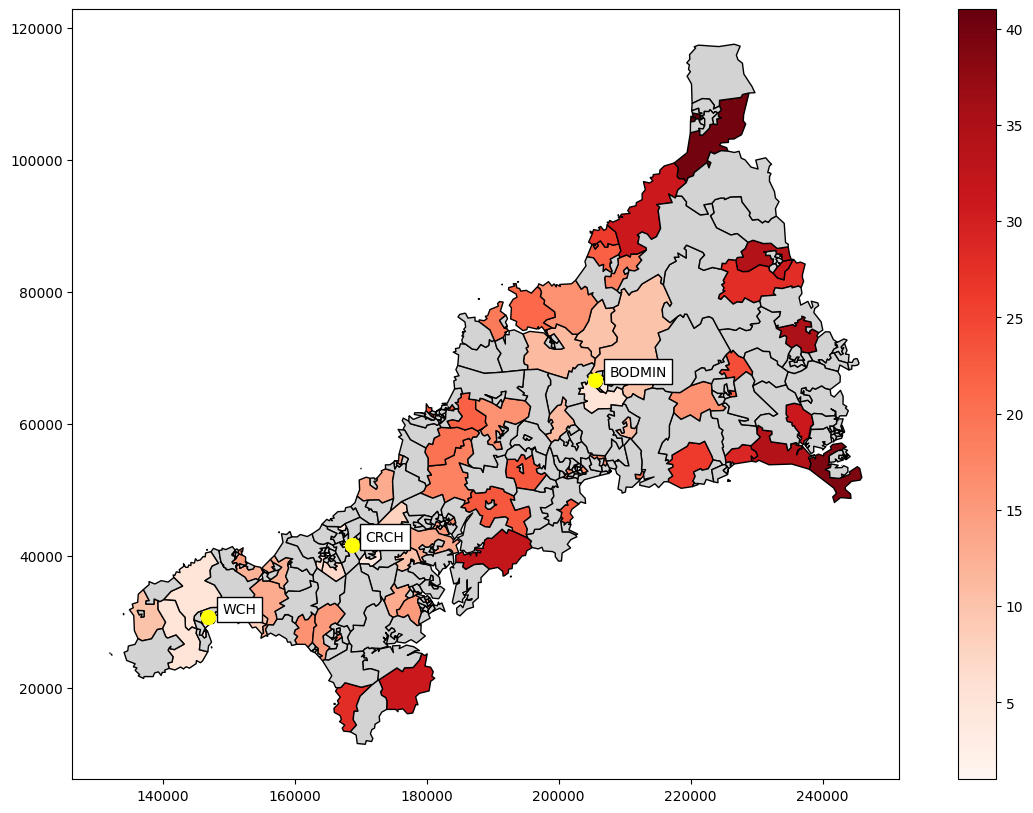

In [25]:
# Plot a choropleth showing the travel time per LSOA for the best solution identified
# Make sure you include a legend
# Use the edgecolor argument with an appropriate colour to make the LSOA boundaries clear
ax = best_result_gdf.plot(
    column="min_cost",
    edgecolor="black",
    figsize=(15,10),
    missing_kwds= dict(color = "lightgrey"),
    cmap="Reds",
    legend=True
    )

# Pull out the relevant clinic sites from the cardiac_clinic_sites df
cardiac_clinic_sites_gdf_filtered = (
    cardiac_clinic_sites_gdf.iloc[results_df.sort_values("weighted_average")
                                  .head(1)["site_indices"].values[0]]
)

# Convert this to EPSG 27700 using the line below so it's using the same CRS as our main dataset
cardiac_clinic_sites_gdf_filtered = cardiac_clinic_sites_gdf_filtered.to_crs("EPSG:27700")

# Plot these clinics as points
# Remember to identify the axis you want to plot this on
# Pass in additional arguments to change the marker size and colour so they are easy to see
cardiac_clinic_sites_gdf_filtered.plot(
        ax=ax,
        color="yellow",
        markersize=100
    )

# Using a for loop, add labels for these clinics
for x,y,label in zip(cardiac_clinic_sites_gdf_filtered.geometry.x,
                     cardiac_clinic_sites_gdf_filtered.geometry.y,
                     cardiac_clinic_sites_gdf_filtered.site):
    ax.annotate(label, xy=(x,y), xytext=(10,3),
                textcoords='offset points', bbox=dict(facecolor="white"))

# Add a basemap
cx.add_basemap(ax, zoom=10, crs=best_result_gdf.crs.to_string())

# Turn off the axis tickmarks
ax.axis('off')

# Add a title
plt.title("Travel Time (minutes) to cardiac clinics - Best Solution")

Now try using the subplots feature of matplotlib to create a plot for every possible combination of clinics. 

Consider the order you might want the plots in.

What additional information is it useful to include in the subplot titles?

First, check the number of results we have so you can work out how many subplots to create.

In [ ]:
len(results_df)

10

Now make the subplots.

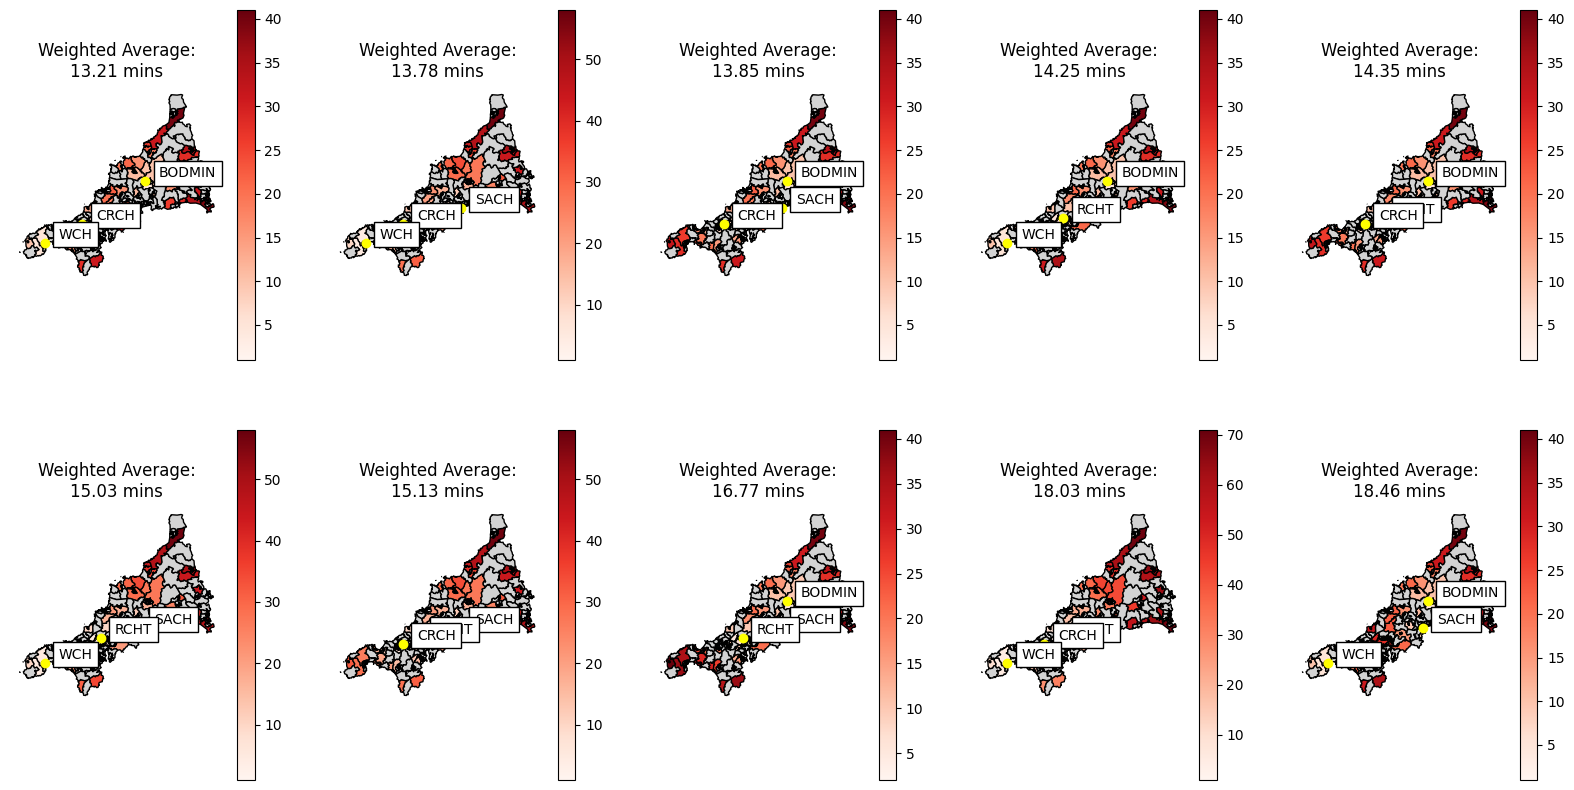

In [ ]:
# Create the subplots
fig, axs = plt.subplots(2, 5, figsize=(20,10))

# Loop through the subplots, plotting one solution on each
for i, ax in enumerate(fig.axes):
    # Get the relevant row for this solution out of results_df
    # Hint - you may want the iloc method for this
    # If you're stuck, investigate what the variable `i` returns throughout the loop
    # Also think about how you could order the solutions from best to worst in your plots
    solution = results_df.sort_values("weighted_average").iloc[[i]]

    # Get the 'problem_df' out of the solution object so you can access the dataframe containing
    # the per-LSOA travel times
    solution_df = solution["problem_df"].values[0]

    # Create the dataframe you need by joining `lsoa_boundaries` with `solution_df`
    result_gdf = pd.merge(
        lsoa_boundaries,
        solution_df,
        how="left",
        left_on="LSOA11CD",
        right_on="sector"
        )

    # Filter down to just LSOA's containing 'Cornwall' in the `LSOA11NMW` column
    result_gdf = result_gdf[result_gdf["LSOA11NMW"].str.contains("Cornwall")]

    # Now add in your plotting code
    # Remember - you'll need to pull back the correct combination of clinics to plot each time!
    ax = result_gdf.plot(
        column="min_cost",
        edgecolor="black",
        figsize=(15,10),
        missing_kwds=dict(color = "lightgrey"),
        ax=ax,
        cmap="Reds",
        legend=True
        )

    cardiac_clinic_sites_gdf_filtered = (
        cardiac_clinic_sites_gdf.iloc[solution["site_indices"].values[0]]
    )

    cardiac_clinic_sites_gdf_filtered = cardiac_clinic_sites_gdf_filtered.to_crs("EPSG:27700")

    cardiac_clinic_sites_gdf_filtered.plot(
        ax=ax,
        color="yellow"
    )

    for x,y,label in zip(cardiac_clinic_sites_gdf_filtered.geometry.x,
                         cardiac_clinic_sites_gdf_filtered.geometry.y,
                         cardiac_clinic_sites_gdf_filtered.site):
        ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords='offset points',
                    bbox=dict(facecolor="white"))

    #cx.add_basemap(ax, zoom=10, crs=result_gdf.crs.to_string())
    ax.axis('off')

    wa_time = solution['weighted_average'].values[0]

    ax.set_title(f"Weighted Average:\n{wa_time:.2f} mins")


## Challenge: Bonus Activities

### 1. Calculate the best solution across the weighted average travel times, unweighted average travel times, and the max travel time. 

How might you rank the outputs?

How might you present the results?

In [ ]:
# We could use this code to add rankings to our outputs
# We could also provide additional graphs for unweighted average or max travel time, or include this in the
# same graph as our initial weighted average graph

results_df = results_df[["site_names", "weighted_average", "unweighted_average", "max"]].round(1)

results_df["rank_weighted_average"] = results_df["weighted_average"].rank(method="min")
results_df["rank_unweighted_average"] = results_df["unweighted_average"].rank(method="min")
results_df["rank_max_travel_time"] = results_df["max"].rank(method="min")

results_df.sort_values("weighted_average")

,site_names,weighted_average,unweighted_average,max,rank_weighted_average,rank_unweighted_average,rank_max_travel_time
8,"BODMIN, CRCH, WCH",13.2,16.4,41,1.0,1.0,1.0
1,"SACH, BODMIN, CRCH",13.8,17.7,41,2.0,3.0,1.0
5,"SACH, CRCH, WCH",13.8,19.5,58,2.0,5.0,7.0
7,"BODMIN, RCHT, WCH",14.2,16.7,41,4.0,2.0,1.0
6,"BODMIN, RCHT, CRCH",14.4,17.7,41,5.0,3.0,1.0
4,"SACH, RCHT, WCH",15.0,20.0,58,6.0,7.0,7.0
3,"SACH, RCHT, CRCH",15.1,21.0,58,7.0,9.0,7.0
0,"SACH, BODMIN, RCHT",16.8,19.9,41,8.0,6.0,1.0
9,"RCHT, CRCH, WCH",18.0,25.4,71,9.0,10.0,10.0
2,"SACH, BODMIN, WCH",18.5,20.4,41,10.0,8.0,1.0


### 2. What's the impact of hospitals across the border?

Let's imagine the Derriford hospital in Plymouth - just across the border - can also provide cardiac clinic services.

Use your routingpy skills from the previous session to grab an additional column of travel data.

Note: this travel data in this exercise is quite old! You may want to instead get new travel data for all of the clinic locations.

Alternatively, for the purpose of this exercise, you could just look up the additional column and add this additional data to your existing travel time dataset. 

Redo the analysis above and compare the outputs. Does adding in Derriford significantly change which clinics we would recommend to keep?

In [ ]:
import routingpy as rp

In [ ]:
# we first need the LSOA centroids for our travel time

lsoa_centroids_2011 = pd.read_csv("../datasets/exercise_2/LSOA_Dec_2011_PWC_in_England_and_Wales_2022.csv")

lsoa_centroids_2011 = geopandas.GeoDataFrame(
    lsoa_centroids_2011,
    geometry=geopandas.points_from_xy(
        x=lsoa_centroids_2011["x"],
        y=lsoa_centroids_2011["y"]
    ),
    crs="EPSG:27700"
).to_crs("EPSG:4326")

lsoa_centroids_2011_cw = lsoa_centroids_2011[lsoa_centroids_2011["LSOA11NM"].str.contains("Cornwall")]

lsoa_centroids_2011_cw.head()

,OBJECTID,LSOA11CD,LSOA11NM,GlobalID,x,y,geometry
29662,29663,E01019026,Cornwall 035C,c535e3aa-5595-4c46-81d8-df492b290cb9,207998.385,53834.361,POINT (-4.70035 50.35304)
29808,29809,E01019027,Cornwall 035D,9a8353ad-39ba-46bf-b9a4-1aea99a30342,212256.014,51892.955,POINT (-4.63960 50.33697)
29809,29810,E01019024,Cornwall 035A,690c5313-1a01-4ba4-875d-280e0f088837,208448.258,54553.904,POINT (-4.69440 50.35965)
29810,29811,E01019025,Cornwall 035B,b8607f5b-b561-4da8-86ee-6168a07c7565,211211.511,52317.910,POINT (-4.65447 50.34045)
29811,29812,E01019022,Cornwall 021E,6e75f627-09bb-4a3d-90b7-6998838befb2,181197.174,61137.548,POINT (-5.08081 50.40927)


In [ ]:
source_coord_pairs = list(
    zip(lsoa_centroids_2011_cw.geometry.x,
    lsoa_centroids_2011_cw.geometry.y)
    )

source_coord_pairs_list = [list(coord_tuple) for coord_tuple in source_coord_pairs]

destination_coord_pairs_list = [[-4.115601642007562,50.416712244531574]]

all_coordinates = []

all_coordinates.extend(source_coord_pairs_list)
all_coordinates.extend(destination_coord_pairs_list)

destination_indices = [i for i in range(len(source_coord_pairs_list), len(all_coordinates))]
source_indices = [i for i in range(len(source_coord_pairs_list))]

ors_api_key = "5b3ce3597851110001cf6248282e2fc33c7e4b428a9b731f8ebb1f9b"

ors_api = rp.ORS(api_key=ors_api_key)

travel_matrix_derriford = ors_api.matrix(
    locations = all_coordinates,
    profile='driving-car',
    sources=source_indices,
    destinations=destination_indices,
    metrics=["distance", "duration"]
)

derriford_travel_df = pd.DataFrame(
    travel_matrix_derriford.durations,
    columns = ["DERRIFORD"],
    index = lsoa_centroids_2011_cw.LSOA11CD
)

derriford_travel_df = derriford_travel_df/60

derriford_travel_df.head()

,DERRIFORD
LSOA11CD,
E01019026,59.853167
E01019027,61.176167
E01019024,58.441333
E01019025,58.211500
E01019022,74.787667


In [ ]:
travel_matrix_exp = pd.merge(travel_matrix, derriford_travel_df.reset_index(), left_on="sector", right_on="LSOA11CD").drop(columns=["LSOA11CD"])

In [ ]:
cardiac_clinic_sites_der_df = pd.concat(
    [cardiac_clinic_sites_df,
    pd.DataFrame(
        {"site": "DERRIFORD",
        "latitude":50.416712244531574,
        "longitude":-4.115601642007562},
        index=["site"]
    )],
    ignore_index=True
)

cardiac_clinic_sites_der_df

,site,latitude,longitude
0,SACH,50.327292,-4.772986
1,BODMIN,50.467420,-4.741224
2,RCHT,50.266402,-5.092207
3,CRCH,50.229144,-5.245264
4,WCH,50.121858,-5.542732
5,DERRIFORD,50.416712,-4.115602


In [ ]:
cardiac_clinic_sites_der_gdf = geopandas.GeoDataFrame(
    cardiac_clinic_sites_der_df,
    geometry= geopandas.points_from_xy(
        x=cardiac_clinic_sites_der_df['longitude'],
        y=cardiac_clinic_sites_der_df['latitude']
    ),
    crs="EPSG:4326"
)

cardiac_clinic_sites_der_gdf

,site,latitude,longitude,geometry
0,SACH,50.327292,-4.772986,POINT (-4.77299 50.32729)
1,BODMIN,50.467420,-4.741224,POINT (-4.74122 50.46742)
2,RCHT,50.266402,-5.092207,POINT (-5.09221 50.26640)
3,CRCH,50.229144,-5.245264,POINT (-5.24526 50.22914)
4,WCH,50.121858,-5.542732,POINT (-5.54273 50.12186)
5,DERRIFORD,50.416712,-4.115602,POINT (-4.11560 50.41671)


In [ ]:
possible_combinations_extra = all_combinations(6, 3)


In [ ]:
facility_location_problem = FacilityLocationObjective(
    demand=attends,
    travel_matrix=travel_matrix_exp,
    merge_col="sector",
    demand_col="n_patients"
    )


results = []

for possible_solution in possible_combinations_extra:
    results.append(
        facility_location_problem.generate_solution_metrics(
            possible_solution
        )
    )

results_df = pd.DataFrame(results)

results_df.sort_values("weighted_average")

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
13,"[1, 3, 4]","BODMIN, CRCH, WCH",13.208607,16.422222,41.0000,sector n_patients BODMIN CRCH WCH ...
7,"[0, 3, 4]","SACH, CRCH, WCH",13.776449,19.455556,58.0000,sector n_patients SACH CRCH WCH mi...
1,"[0, 1, 3]","SACH, BODMIN, CRCH",13.849372,17.655556,41.0000,sector n_patients SACH BODMIN CRCH ...
11,"[1, 2, 4]","BODMIN, RCHT, WCH",14.245666,16.711111,41.0000,sector n_patients BODMIN RCHT WCH ...
10,"[1, 2, 3]","BODMIN, RCHT, CRCH",14.354453,17.733333,41.0000,sector n_patients BODMIN RCHT CRCH ...
5,"[0, 2, 4]","SACH, RCHT, WCH",15.025105,19.966667,58.0000,sector n_patients SACH RCHT WCH mi...
4,"[0, 2, 3]","SACH, RCHT, CRCH",15.133891,20.988889,58.0000,sector n_patients SACH RCHT CRCH m...
14,"[1, 3, 5]","BODMIN, CRCH, DERRIFORD",15.416015,18.500633,41.0000,sector n_patients BODMIN CRCH DERRI...
8,"[0, 3, 5]","SACH, CRCH, DERRIFORD",15.934427,20.989191,58.0000,sector n_patients SACH CRCH DERRIFO...
0,"[0, 1, 2]","SACH, BODMIN, RCHT",16.772863,19.888889,41.0000,sector n_patients SACH BODMIN RCHT ...


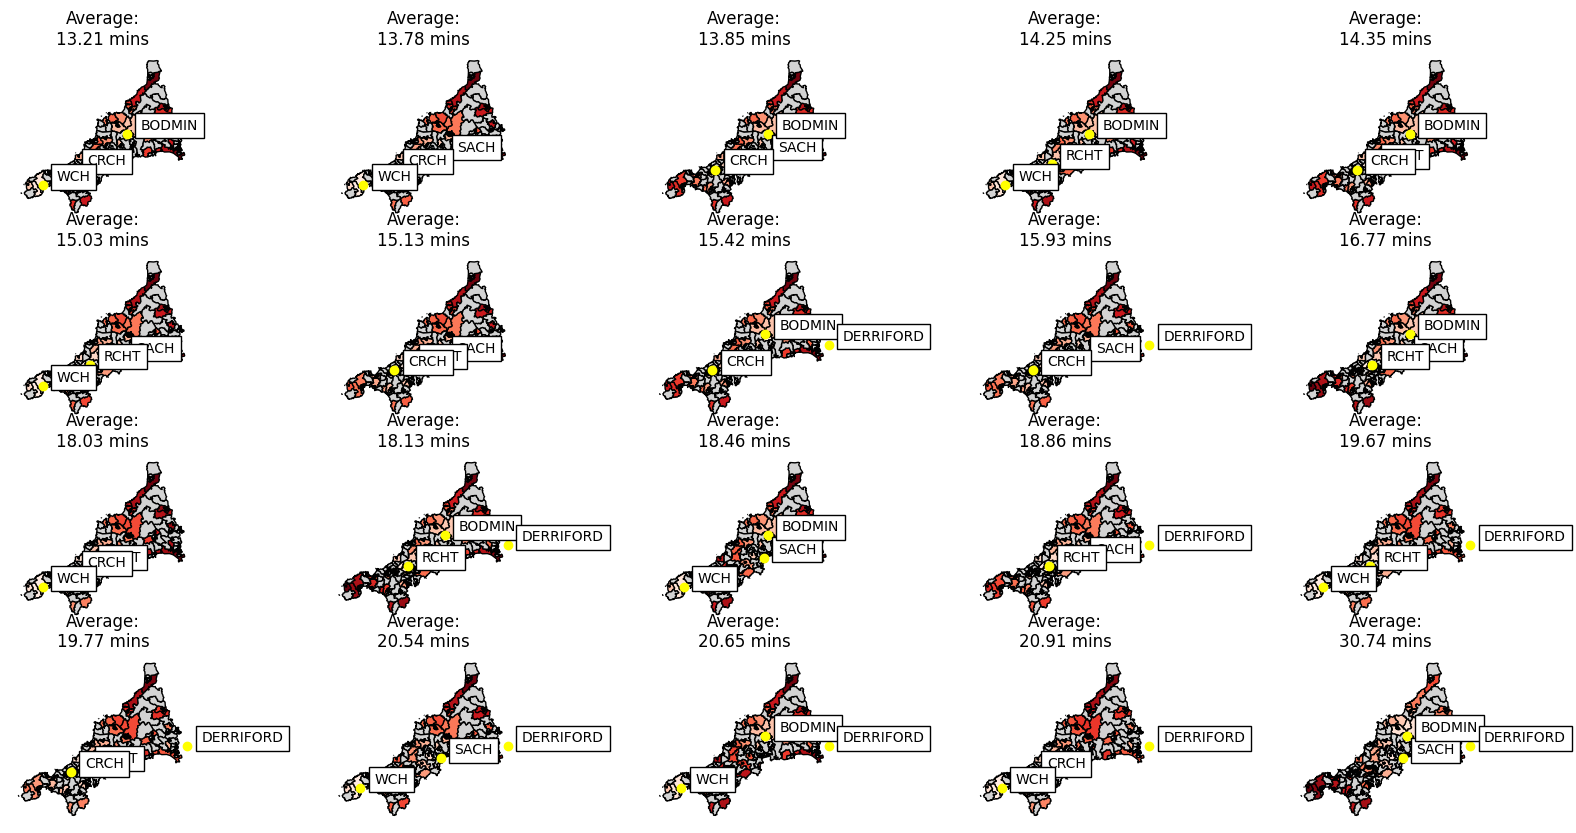

In [ ]:
def plot_results(rows, cols):

    fig, axs = plt.subplots(rows, cols, figsize=(20,10))

    for i, ax in enumerate(fig.axes):
        solution = results_df.sort_values("weighted_average").iloc[[i]]
        solution_df = solution["problem_df"].values[0]

        result_gdf = pd.merge(
            lsoa_boundaries,
            solution_df,
            how="left",
            left_on="LSOA11CD",
            right_on="sector"
            )

        result_gdf = result_gdf[result_gdf["LSOA11NMW"].str.contains("Cornwall")]

        ax = result_gdf.plot(
            column="min_cost",
            edgecolor="black",
            figsize=(15,10),
            missing_kwds=dict(color = "lightgrey"),
            ax=ax,
            cmap="Reds"
            )

        cardiac_clinic_sites_gdf_filtered = cardiac_clinic_sites_der_gdf.iloc[solution["site_indices"].values[0]]

        cardiac_clinic_sites_gdf_filtered = cardiac_clinic_sites_gdf_filtered.to_crs("EPSG:27700")

        cardiac_clinic_sites_gdf_filtered.plot(
            ax=ax,
            color="yellow"
        )

        for x,y,label in zip(cardiac_clinic_sites_gdf_filtered.geometry.x, cardiac_clinic_sites_gdf_filtered.geometry.y, cardiac_clinic_sites_gdf_filtered.site):
            ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords='offset points', bbox=dict(facecolor="white"))

        #cx.add_basemap(ax, zoom=10, crs=result_gdf.crs.to_string())
        ax.axis('off')

        wa_time = solution['weighted_average'].values[0]

        ax.set_title(f"Average:\n{wa_time:.2f} mins")

plot_results(4,5)

### 3. What if one option must always be included?

To take this even further, switch to keeping 4 clinic open - but one of them will *always* be Derriford as we don't have any control over the decisions around that clinic (as it's not in our commisioning area). 

How could you create these combinations? 

Rerun your analysis.

In [ ]:
# Derriford is index 5 (site 6)
# WE'll get the other possibilities, then add Derriford to each
possible_combinations_3_of_5 = all_combinations(5, 3)

possible_combination_always_derr = [np.concatenate([i, [5]]) for i in possible_combinations_3_of_5]

In [ ]:
facility_location_problem = FacilityLocationObjective(
    demand=attends,
    travel_matrix=travel_matrix_exp,
    merge_col="sector",
    demand_col="n_patients"
    )


results = []

for possible_solution in possible_combination_always_derr:
    results.append(
        facility_location_problem.generate_solution_metrics(
            possible_solution
        )
    )

results_df = pd.DataFrame(results)

results_df.sort_values("weighted_average")

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
8,"[1, 3, 4, 5]","BODMIN, CRCH, WCH, DERRIFORD",13.188280,16.156189,41.0,sector n_patients BODMIN CRCH WCH ...
5,"[0, 3, 4, 5]","SACH, CRCH, WCH, DERRIFORD",13.706693,18.644746,58.0,sector n_patients SACH CRCH WCH DE...
1,"[0, 1, 3, 5]","SACH, BODMIN, CRCH, DERRIFORD",13.829045,17.389522,41.0,sector n_patients SACH BODMIN CRCH ...
7,"[1, 2, 4, 5]","BODMIN, RCHT, WCH, DERRIFORD",14.225339,16.445078,41.0,sector n_patients BODMIN RCHT WCH ...
6,"[1, 2, 3, 5]","BODMIN, RCHT, CRCH, DERRIFORD",14.334126,17.467300,41.0,sector n_patients BODMIN RCHT CRCH ...
4,"[0, 2, 4, 5]","SACH, RCHT, WCH, DERRIFORD",14.955348,19.155857,58.0,sector n_patients SACH RCHT WCH DE...
3,"[0, 2, 3, 5]","SACH, RCHT, CRCH, DERRIFORD",15.064134,20.178080,58.0,sector n_patients SACH RCHT CRCH D...
0,"[0, 1, 2, 5]","SACH, BODMIN, RCHT, DERRIFORD",16.752536,19.622856,41.0,sector n_patients SACH BODMIN RCHT ...
9,"[2, 3, 4, 5]","RCHT, CRCH, WCH, DERRIFORD",17.546095,22.267896,71.0,sector n_patients RCHT CRCH WCH DE...
2,"[0, 1, 4, 5]","SACH, BODMIN, WCH, DERRIFORD",18.438728,20.122856,41.0,sector n_patients SACH BODMIN WCH ...


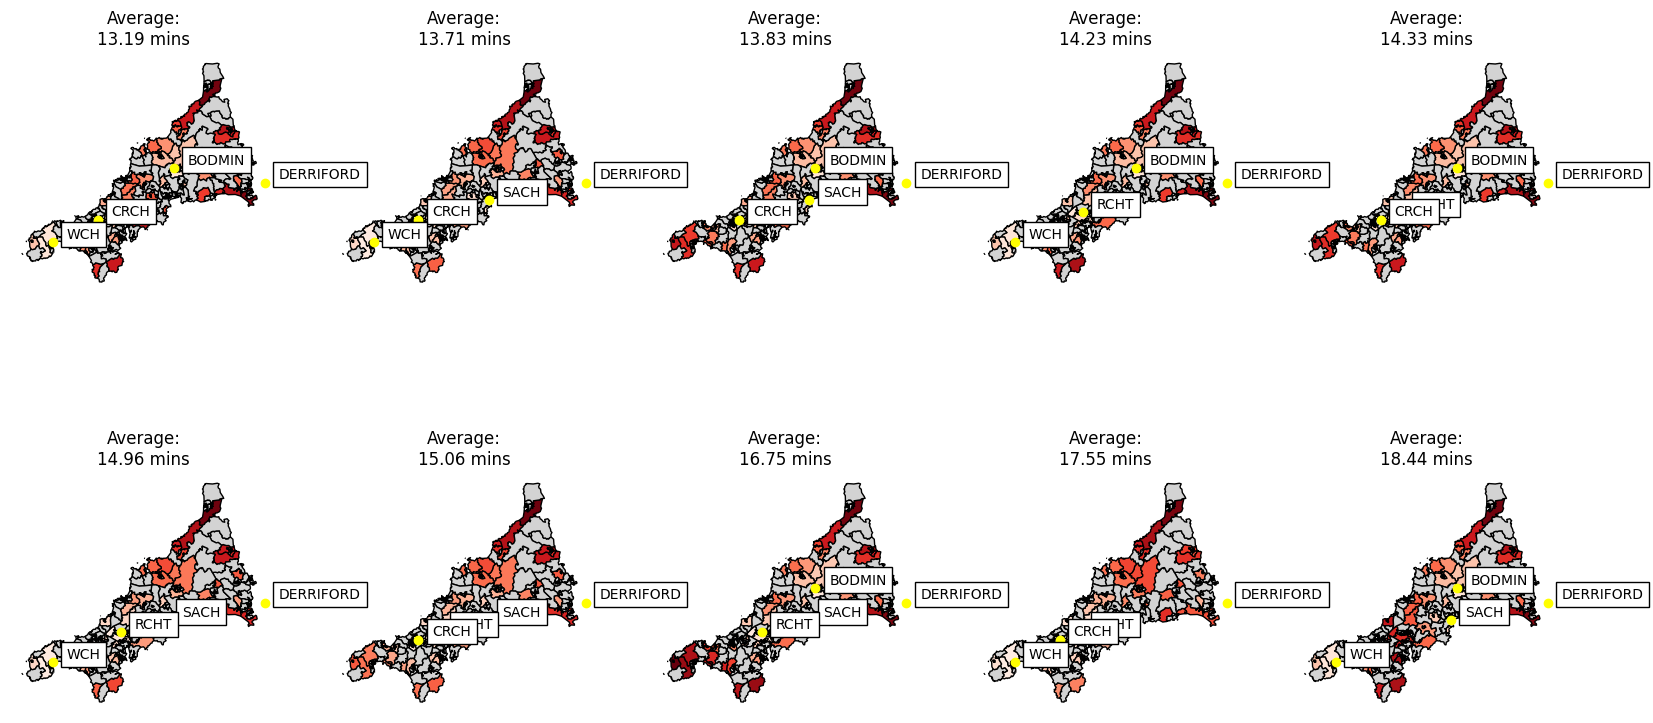

In [ ]:
plot_results(2,5)

### 4. How might you account for LSOAs without any demand?

You may have noticed that some LSOAs appear to have no demand in the time period shown. 

Think about how this might affect the results. 

How might you create an additional demand dataframe that ensures every LSOA in Cornwall is included? 

A simple option would involve making sure you've got every LSOA in Cornwall as a demand centre.

Create two sets of plots containing this dataset
- all possible subplots with three Cornish clinics + Derriford
- all possible subplots with just the three Cornish clinics + Derriford not included.

Note: for this exercise we are just expecting you to use a very simple method to ensure there's data for all LSOAs. But what additional information might you need to make a more detailed estimate about the demand?
You may need to look for additional datasets - e.g. population counts, age/gender data, IMD, details about cardiac risk factors, diagnosis data (in a real scenario), stakeholder insight.

In [ ]:
# First exploring what our initial attendance/demand dataframe looked like
attends

,sector,n_patients
0,E01018757,3
1,E01018758,10
2,E01018761,19
3,E01018763,2
4,E01018768,6
...,...,...
85,E01019057,51
86,E01019064,24
87,E01019071,20
88,E01033289,29


In [ ]:
# Creating a new dataframe containing all cornish LSOAs and setting demand to 1 in all
# If we had more knowledge about likely variations in demand, we could adjust it in some way
# e.g. use a population estimate adjuted by some demographic factors
demand_cornwall = lsoa_boundaries[lsoa_boundaries["LSOA11NM"].str.contains("Cornwall")][['LSOA11CD']].reset_index(drop=True)
demand_cornwall["demand"] = 1
demand_cornwall

,LSOA11CD,demand
0,E01018750,1
1,E01018751,1
2,E01018752,1
3,E01018753,1
4,E01018754,1
...,...,...
321,E01019076,1
322,E01033289,1
323,E01033291,1
324,E01033292,1


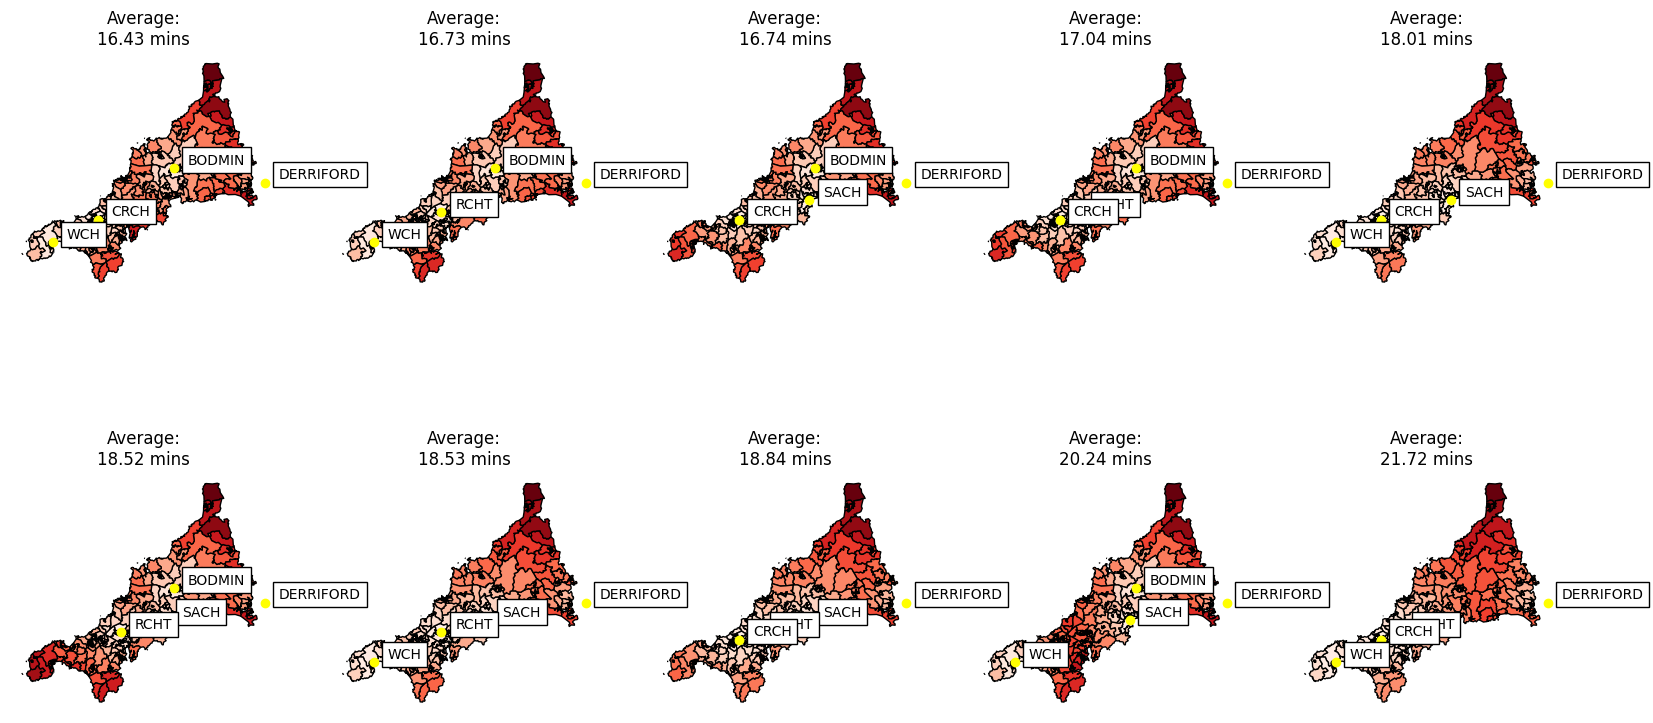

In [ ]:
# Now we'll reevaluate our solution

facility_location_problem = FacilityLocationObjective(
    demand=demand_cornwall.rename(columns={"LSOA11CD":"sector"}),
    travel_matrix=travel_matrix_exp,
    merge_col="sector",
    demand_col="demand"
    )

results = []

for possible_solution in possible_combination_always_derr:
    results.append(
        facility_location_problem.generate_solution_metrics(
            possible_solution
        )
    )

results_df = pd.DataFrame(results)

plot_results(2,5)

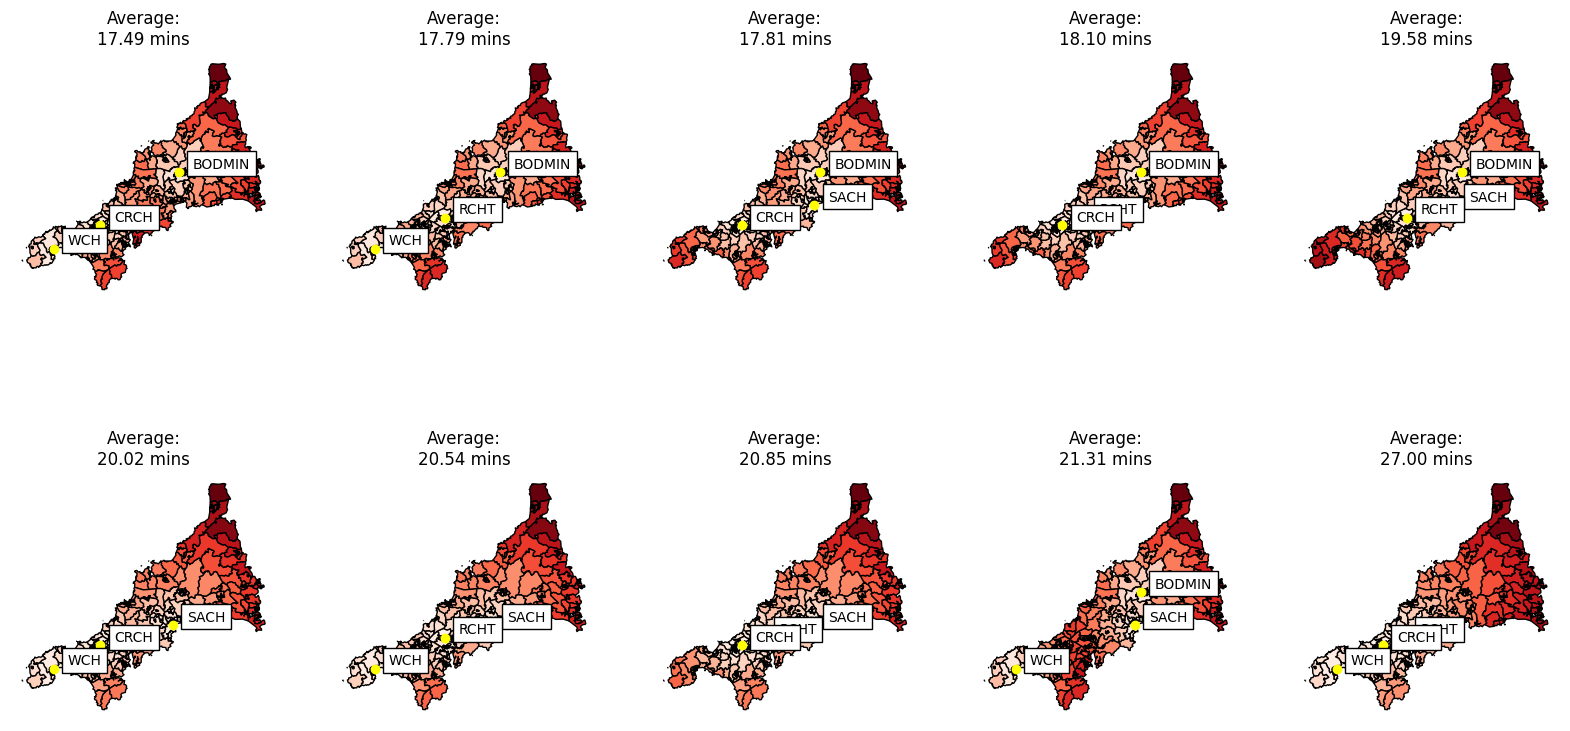

In [ ]:
# let's compare this to a reevaluated solution without derriford

# Now we'll reevaluate our solution

facility_location_problem = FacilityLocationObjective(
    demand=demand_cornwall.rename(columns={"LSOA11CD":"sector"}),
    travel_matrix=travel_matrix,
    merge_col="sector",
    demand_col="demand"
    )

results = []

for possible_solution in possible_combinations:
    results.append(
        facility_location_problem.generate_solution_metrics(
            possible_solution
        )
    )

results_df = pd.DataFrame(results)

plot_results(2,5)